In [1]:
using Gen
using Random
using PyPlot
include("../data/synthetic.jl")
using .Synthetic

In [106]:
# data for debuging
# 2 objects with size 50 
n = 100
obj_size = 50
X = zeros(n)
Y = zeros(n)
U = zeros(n)
T = zeros(n)

for i in 1:n
    X[i] = normal(0, 1)
    T[i] = normal(0, 1)
    
    if i < 51
        Y[i] = normal(2*T[i]+1, 0.2)
        U[i] = 1
    else
        Y[i] = normal(-2*T[i]-1, 1)
        U[i] = 0
    end
    
end

In [109]:
# generate initial parameters from prior
# ty, xy, uy, ynoise
@gen function generateLS(mean, scale)
    LS = @trace(normal(mean, scale), :LS)
    return LS
end
@gen function generateNoise(shape, scale)
    Noise = @trace(inv_gamma(shape, scale), :Noise)
    return Noise
end
nObj = 2
MappedGenerateLS = Map(generateLS)
MappedGenerateNoise = Map(generateNoise)

Map{Any,Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any], ##generateNoise#452, Bool[0, 0], false))

In [110]:
# list of obj labels: [1,1,1, ... j,j,j]
label = 1
obj_label = zeros(n)
for i in 1:n
    obj_label[i] = label
    if (i % obj_size) == 0
        label += 1
    end 
end 
Int(obj_label[1])

1

In [111]:
@gen function my_model(xs::Vector{Float64}, ts::Vector{Float64}, obj_label, nX, nObj)
    beta = @trace(MappedGenerateLS(fill(0.0, nX), fill(1.0, nX)), :beta) #xyLS
    theta = @trace(MappedGenerateLS(fill(0.0, nObj), fill(1.0, nObj)), :theta) #tyLS
    alpha = @trace(MappedGenerateLS(fill(0.0, nObj), fill(1.0, nObj)), :alpha) #alpha
    noise = @trace(MappedGenerateNoise(fill(4.0, nObj), fill(4.0, nObj)), :sigma)
    for (i, x) in enumerate(xs)
        obj = Int(obj_label[i])
        @trace(normal(sum(beta.*xs[i]) + theta[obj] * ts[i] + alpha[obj], noise[obj]), "y-$i")
    end
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}, Array{Float64,1}, Any, Any, Any], ##my_model#453, Bool[0, 0, 0, 0, 0], false)

In [112]:
constraints = choicemap()
for (i, y) in enumerate(Y)
    constraints["y-$i"] = y
end
n_run = 1000
PosteriorSamples = []
(trace, _) = generate(my_model, (X, T, obj_label, 1, nObj), constraints)
for iter=1:n_run
    (trace, _) = mh(trace, select(:beta))
    (trace, _) = mh(trace, select(:theta))
    (trace, _) = mh(trace, select(:alpha))
    (trace, _) = mh(trace, select(:sigma))
    
    push!(PosteriorSamples, get_choices(trace))
end

Y_pred = zeros(n)
for i in 1:n  
    beta = PosteriorSamples[n_run][:beta=>1=>:LS]
    theta = [PosteriorSamples[n_run][:theta=>k=>:LS] for k in 1:2]
    alpha = [PosteriorSamples[n_run][:alpha=>k=>:LS] for k in 1:2]
    noise = [PosteriorSamples[n_run][:sigma=>k=>:Noise] for k in 1:2]
    obj = Int(obj_label[i])
    Y_pred[i] = normal(sum(beta.*X[i]) + theta[obj] * T[i] + alpha[obj], noise[obj])
end

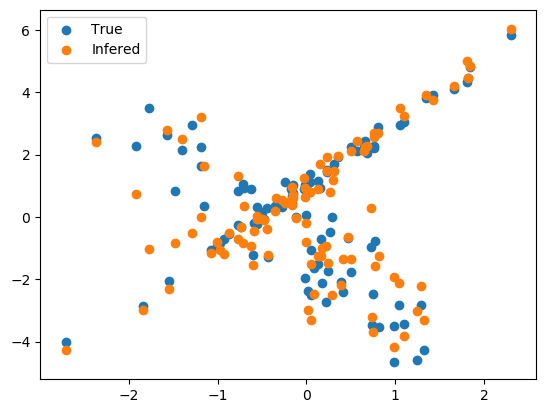

PyObject <matplotlib.legend.Legend object at 0x1600a1d10>

In [119]:
scatter(T, Y, label="True")
scatter(T, Y_pred, label="Infered")
legend()